#Imports


In [28]:
from google.colab import drive
import zipfile
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve


#Extracting Test Data

In [29]:


# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/test.zip'  # Replace with your actual zip file path

# Specify the destination folder in Colab runtime storage
extracted_folder_path = '/content/test1'

# Create the destination folder if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

extracted_files = os.listdir(extracted_folder_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preprocessing

As the annotations are in xml format so functions are generated to read xml files and extract annotations accordingly.

In pre processing, image values were normalzied and annoattion values were also normalized in range of 0 to 1.

In [30]:


# Function to read annotations
def read_annotations(xml_file, folder_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(folder_path, filename)
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    depth = int(root.find('size/depth').text)
    # print(image_path)
    image = cv2.imread(image_path)

    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymin = int(obj.find('bndbox/ymin').text)
        ymax = int(obj.find('bndbox/ymax').text)

        annotations.append({
            'name': name,
            'bbox': (xmin, ymin, xmax, ymax)
        })

    return {
        'filename': filename,
        'image_path': image_path,
        'width': width,
        'height': height,
        'depth': depth,
        'image': image,
        'annotations': annotations
    }

# Function to preprocess images and annotations for training
def preprocess_data(image, annotations, width,height,input_shape=(224, 224)):
    # Resize the image
    image = cv2.resize(image, input_shape)

    # Normalize pixel values to be in the range [0, 1]
    image = image / 255.0

    # Resize and normalize bounding box coordinates
    processed_annotations = []
    for annotation in annotations:
        bbox = annotation['bbox']
        xmin, ymin, xmax, ymax = bbox

        # Scale bounding box coordinates based on resizing factor
        x_scale = input_shape[1] / (width*224)
        y_scale = input_shape[0] / (height*224)

        processed_bbox = (
            float(xmin * x_scale),
            float(ymin * y_scale),
            float(xmax * x_scale),
            float(ymax * y_scale)
        )

        processed_annotations.append({
            'name': annotation['name'],
            'bbox': processed_bbox
        })
    # print(processed_bbox)
    return image, processed_annotations

# Load and preprocess the dataset
def load_dataset(folder_path, max_images):
    dataset = []
    image_count = 0

    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            xml_file_path = os.path.join(folder_path, filename)
            data = read_annotations(xml_file_path, folder_path)

            # Preprocess the image and annotations
            processed_image, processed_annotations = preprocess_data(data['image'], data['annotations'],data['width'],data['height'])

            dataset.append({
                'image': processed_image,
                'annotations': processed_annotations
            })

            image_count += 1
            if image_count >= max_images:
                break

    return dataset



#Data Loading

In [31]:
folder_path = '/content/test1/test'

# Load and preprocess the dataset
dataset = load_dataset(folder_path, max_images=450)
unique_categories = set()
for example in dataset:
    for annotation in example['annotations']:
        unique_categories.add(annotation['name'])

# Add a new class for "no object"
unique_categories.add('no_object')

unique_category_to_index= {'bicycle': 0, 'person': 1, 'car': 2, 'dog': 3, 'no_object': 4}

# Create TensorFlow Dataset with multiple bounding boxes per image
data = np.array([example['image'] for example in dataset])

# Assuming you have already initialized targets like this:
num_images = len(dataset)
num_annotations_per_image = 5
num_categories = 5

targets = {
    'labels': np.zeros((num_images, num_annotations_per_image, num_categories), dtype=np.float64),
    'boxes': np.zeros((num_images, num_annotations_per_image, 4), dtype=np.float64)
}

for i, example in enumerate(dataset):
    image_id = np.array([i])
    for j, anno in enumerate(example['annotations']):
        # print(j)
        if j < num_annotations_per_image:
            # Extract bounding box coordinates
            xmin, ymin, xmax, ymax = anno['bbox']
            category_label = unique_category_to_index[anno['name']]

            # Store bounding box coordinates and category label in targets
            targets['boxes'][i, j, :] = [xmin, ymin, xmax, ymax]

            # Convert category label to one-hot encoding
            one_hot_encoding = np.zeros(num_categories, dtype=np.float64)
            one_hot_encoding[category_label] = 1.0
            targets['labels'][i, j, :] = one_hot_encoding

    # Add "no object" class for remaining slots
    for j in range(len(example['annotations']), num_annotations_per_image):
        targets['labels'][i, j, unique_category_to_index['no_object']] = 1.0

# Create TensorFlow Dataset
test_ds = tf.data.Dataset.from_tensor_slices(
    ({'mobilenetv2_1.00_224_input': data},
     {'classification': targets['labels'], 'reshape_bbox': targets['boxes']}))
# print(targets['labels'])
print(len(test_ds))

386


#Converting dataset in batch form to allign dimensions

In [32]:
batch_size = 1

# Batch the dataset
test_ds = test_ds.batch(batch_size)


#Loading Saved Model

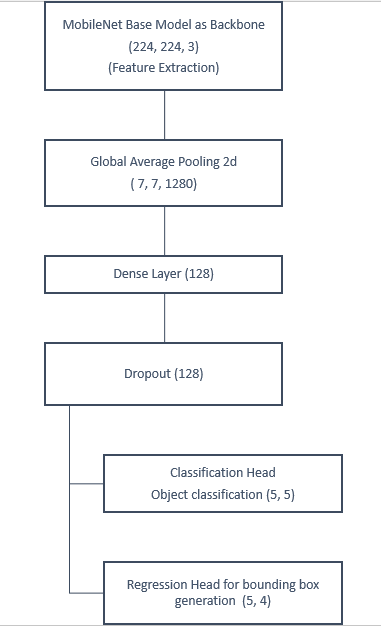

As shown in the figure, we used pre-trained MobileNet architecture as the backbone of our feature extraction layer. Its input size is 224,224,3 which is standard for this network. After this, we used pooling and then used a dense layer which will be trained on our dataset. A dropout layer was used to avoid the chances of overfitting. Lastly, classification head is used to classify objects in boxes, its shape is (5,5) which means it can classify 5 objects per image and a total of 5 classes. Then Regression head comes to predict bounding box values, its output shape is (5,4) which means per image 5 boxes each with 4 values that are xmin, xmax, ymin, and ymax.

In [33]:

# Load the model
loaded_model = load_model("/content/drive/MyDrive/trained_model.keras")
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mobilenetv2_1.00_224_input  [(None, 224, 224, 3)]        0         []                            
  (InputLayer)                                                                                    
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['mobilenetv2_1.00_224_input[0
 tional)                                                            ][0]']                        
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['mobilenetv2_1.00_224[0][0]']
 GlobalAveragePooling2D)                                                                      

as shown above, summary of model, we have total of 2427757 parameters, out of which 169773 are trainable becuase of new layers which we added and 2257984 are non trainable because of base model which we freezed.

#Evaluating the Model

After evaluating loaded model on test, we got accuracy of around 40% and loss of 0.1477 (bounding box).

In [34]:
test_loss, test_classification_loss, test_reshape_bbox_loss, test_classification_accuracy = loaded_model.evaluate(test_ds)


386/386 [==============================] - 20s 45ms/step - loss: 4.0354 - classification_loss: 3.8876 - reshape_bbox_loss: 0.1477 - classification_accuracy: 0.3995


#Performance Metrics

Confusion matrix was calculated along with average IOU score on validation dataset. Average IOU is 0.12 which is quite low :(. It means overlapping of predicted boxes and ground truth is only 12%.

In [35]:

# Make predictions using the model
predictions = loaded_model.predict(test_ds)

# Classification metrics
classification_predictions = predictions[0].reshape(-1, 5)
classification_targets = np.concatenate([y['classification'] for _, y in test_ds], axis=0).reshape(-1, 5)
classification_targets = np.argmax(classification_targets, axis=-1)  # Convert one-hot encoding to class indices

print("Performance Metrics:")
print(classification_report(classification_targets, np.argmax(classification_predictions, axis=-1), zero_division=1))

# Bounding box metrics (IoU)
iou_predictions = predictions[1].reshape(-1, 4)
iou_targets = np.concatenate([y['reshape_bbox'] for _, y in test_ds], axis=0).reshape(-1, 4)

# Compute IoU for each prediction
def calculate_iou(box1, box2):
    x1, y1, width1, height1 = box1
    x2, y2, width2, height2 = box2

    intersection_x = max(x1, x2)
    intersection_y = max(y1, y2)
    intersection_w = max(0, min(x1 + width1, x2 + width2) - intersection_x)
    intersection_h = max(0, min(y1 + height1, y2 + height2) - intersection_y)

    intersection_area = intersection_w * intersection_h
    union_area = (width1 * height1) + (width2 * height2) - intersection_area

    iou = intersection_area / union_area
    return iou

iou_scores = [calculate_iou(pred_box, target_box) for pred_box, target_box in zip(iou_predictions, iou_targets)]
average_iou = np.mean(iou_scores)

print(f"\nAverage IoU: {average_iou}")


386/386 [==============================] - 18s 45ms/step
Performance Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      0.00      0.00        27
           2       1.00      0.00      0.00       877
           3       0.00      1.00      0.00         0
           4       0.88      0.75      0.81      1023

    accuracy                           0.40      1930
   macro avg       0.58      0.35      0.16      1930
weighted avg       0.93      0.40      0.43      1930


Average IoU: 0.12040031810595347


#Visualizing Some Images from test set

1/1 [==============================] - 0s 400ms/step


Category: car
Category: car
Category: no_object
Category: no_object
Category: no_object


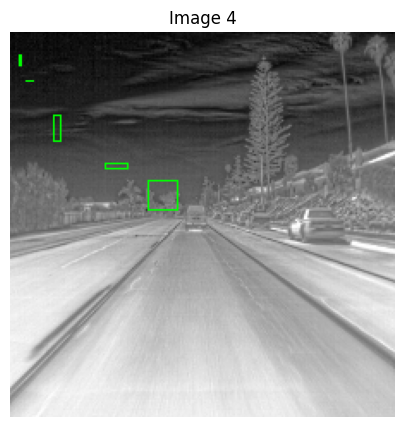

In [36]:


def plot_images_with_predictions_for_image(model, dataset, category_dict, image_index=2, figure_size=(15, 5), confidence_threshold=0.5):
    # Select the specific image from the dataset
    selected_dataset = dataset.skip(image_index - 1).take(1)

    # Make predictions using the model
    predictions = model.predict(selected_dataset)
    probabilities = predictions[0]
    bounding_boxespred = predictions[1]

    # Set the figure size
    plt.figure(figsize=figure_size)

    for i, (features, targets) in enumerate(selected_dataset):
        image = features['mobilenetv2_1.00_224_input']  # Extracting the image data from the dictionary
        image_array = image.numpy()[0]  # Removing the batch dimension

        image = cv2.cvtColor((image_array * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

        # Plot the image
        plt.subplot(1, 1, 1)
        plt.imshow(image)

        # Plot the predicted bounding boxes with confidence above the threshold
        for j, bbox in enumerate(bounding_boxespred[i]):
            xmin, ymin, xmax, ymax = bbox

            #Inverse Scaling
            xmin *= 224
            xmax *= 224
            ymin *= 224
            ymax *= 224

            width = xmax - xmin
            height = ymax - ymin

            # category ID with the highest probability
            category_id = np.argmax(probabilities[i, j])

            # category name from the dictionary
            category_name = [k for k, v in category_dict.items() if v == category_id][0]

            # Print the category name
            print(f"Category: {category_name}")

            # Draw the bounding box
            cv2.rectangle(image_array, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 1)

        plt.axis('off')
        plt.title(f'Image {image_index}')
        plt.imshow(image_array)

    plt.show()

# Define your category dictionary
category_dict = {'bicycle': 0, 'person': 1, 'dog': 2, 'car': 3, 'no_object': 4}

# Call the function to plot images with predicted bounding boxes and category names
plot_images_with_predictions_for_image(loaded_model, test_ds, category_dict, image_index=4)


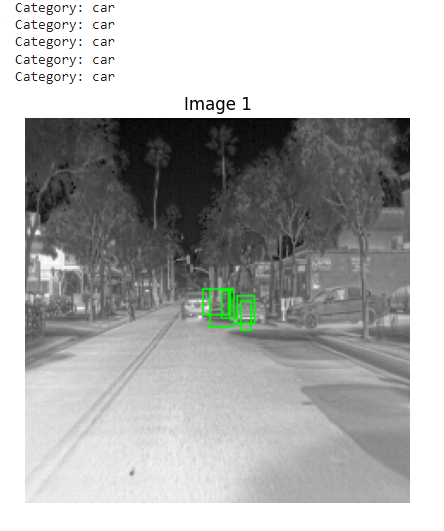

As the random image above shows, it correctly identifies that 5 cars in image (max number of objects) while boxes are not close. Few boxes were close to real object but few were totally garbage.

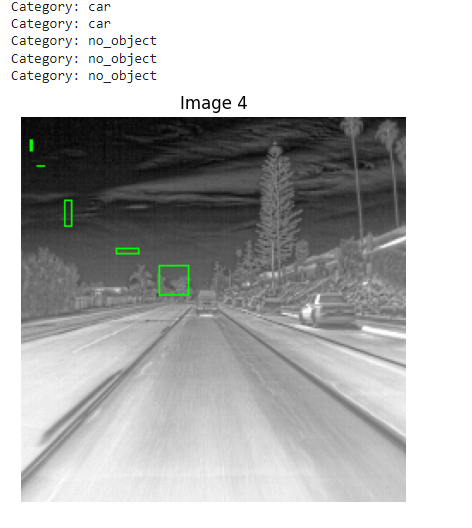

As in 2nd image, it again correctly identitfies that there are only two objects in image, both are car, all other are no objects, in this case bounding boxes are totally far away from ground truths.